<h1 style="font-size:40px; font-family:Courier New"><center>Spaceship Titanic <br/> Exploratory Data Analysis</center></h1>

<h3 style="font-size:16px; "><center>BY ANDREAS PALMGREN</center></h3>

---
> Exploratory data analysis is the work of a detective. Understanding the possibilities of your data is the first step in laying the groundwork for future modeling. With this notebook, we try to make sense of our data and demonstrate how data can be analyzed. We'll look for trends, limitations, and other characteristics linked to the questions we're interested in as part of our investigation.

---

<div class="alert alert-block alert-warning">
<b> This notebook is still a work in progress. </b>
</div>

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from matplotlib.patches import Rectangle
import matplotlib.patheffects as path_effects
import seaborn as sns
from scipy.stats import gaussian_kde
from IPython.core.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import XGBClassifier
import xgboost as xgb

bg_color = "#212946"

neon_colors = [
    "#9cfaff",
    "#ffb3dd"
]

rc = {"axes.spines.left" : True,
      "axes.spines.right" : False,
      "axes.spines.bottom" : True,
      "axes.spines.top" : False,
      "figure.subplot.hspace" : 0.7,
      "figure.titleweight" : "bold",
      "axes.titleweight" : "bold",
      "font.weight" : "bold",
      "figure.facecolor" : bg_color,
      "figure.edgecolor" : "black",
      "axes.facecolor" : bg_color,
      "figure.edgecolor" : "black",
      "xtick.color" : "#5a658f",
      "ytick.color" : "#5a658f",
      "axes.labelcolor" : "#5a658f",
      "axes.labelweight" : "bold"}
plt.rcParams.update(rc)


# Font on kaggle
from fontTools.ttLib import TTFont
from matplotlib import font_manager
title_font = "Neon"
#font_manager.fontManager.addfont("../input/neon-font/NEON-E2WG.TTF")

directory_path = "../input/spaceship-titanic/"
directory_path = "input/"

In [3]:
# Load data
df_train = pd.read_csv(f'{directory_path}train.csv')
df_test = pd.read_csv(f'{directory_path}/test.csv')

df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
print(" \033[1m", "# of passengers within training set: ", len(df_train), "\033[0m")
print(" \033[1m", "# of passengers within testing set: ", len(df_test), "\033[0m")

  # of passengers within training set:  8693 
  # of passengers within testing set:  4277 


---

# **EDA**

> We begin by looking into missing values. All features except `PassengerId` and our target `Transported` seem to have missing values.

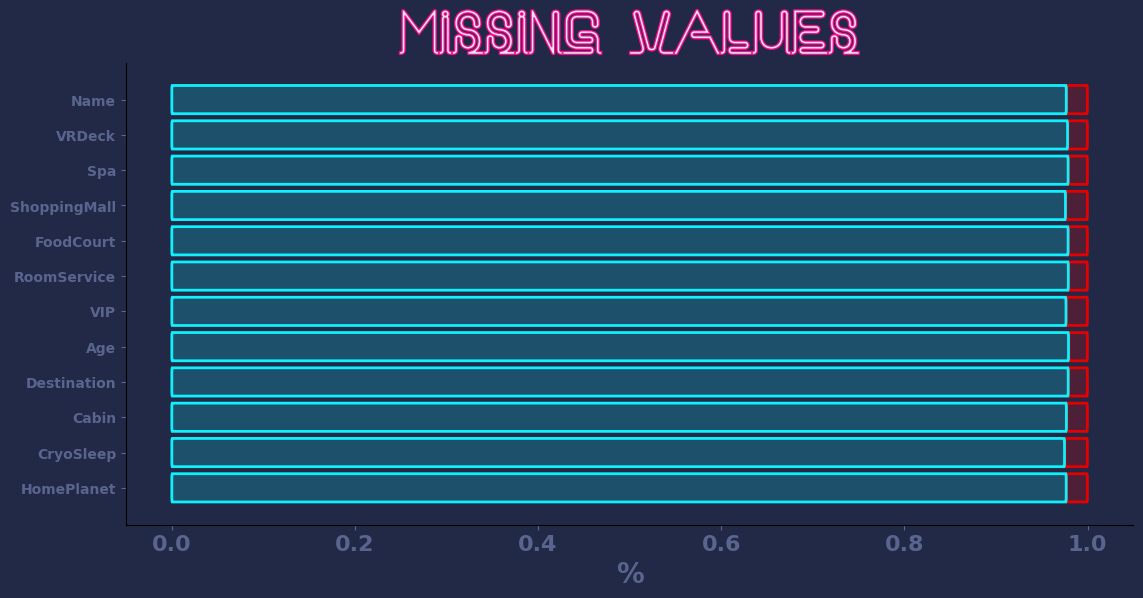

In [5]:
fig, ax = plt.subplots(figsize=(13, 6))

# Bar plots
for i, column in enumerate(df_train.columns[1:-1]):
    missing_dt = (df_train[column].isna().sum()/len(df_train))
    ax.barh(i, 1-missing_dt, color="#0ff0fc", height=0.9)

    ax.barh(i, missing_dt, left=1-missing_dt, color="#e60000", height=0.9)

# Round edges
new_patches = []
for i, patch in enumerate(reversed(ax.patches)):
    bb = patch.get_bbox()
    color=patch.get_facecolor()
    if i%2 == 0:
        fc = "#4d2038"
    else: fc = "#1d506a"
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                        abs(bb.width), abs(bb.height),
                        boxstyle="round,pad=-0.0002,rounding_size=0.0005",
                        ec=color, fc=fc,
                        mutation_aspect=250, lw=2
                        )
    patch.remove()
    new_patches.append(p_bbox)
for patch in new_patches:
    ax.add_patch(patch)

# Figure text adjustments
ax.set_yticks(np.arange(0, 12))
ax.set_yticklabels(df_train.columns[1:-1])
ax.set_title("Missing values", size=40, c="white", path_effects=[path_effects.Stroke(linewidth=1, foreground="#ff0490", alpha=0.9)], family=title_font)
ax.tick_params(axis="x", which="major", labelsize=16)
ax.set_xlabel("%", size=20);

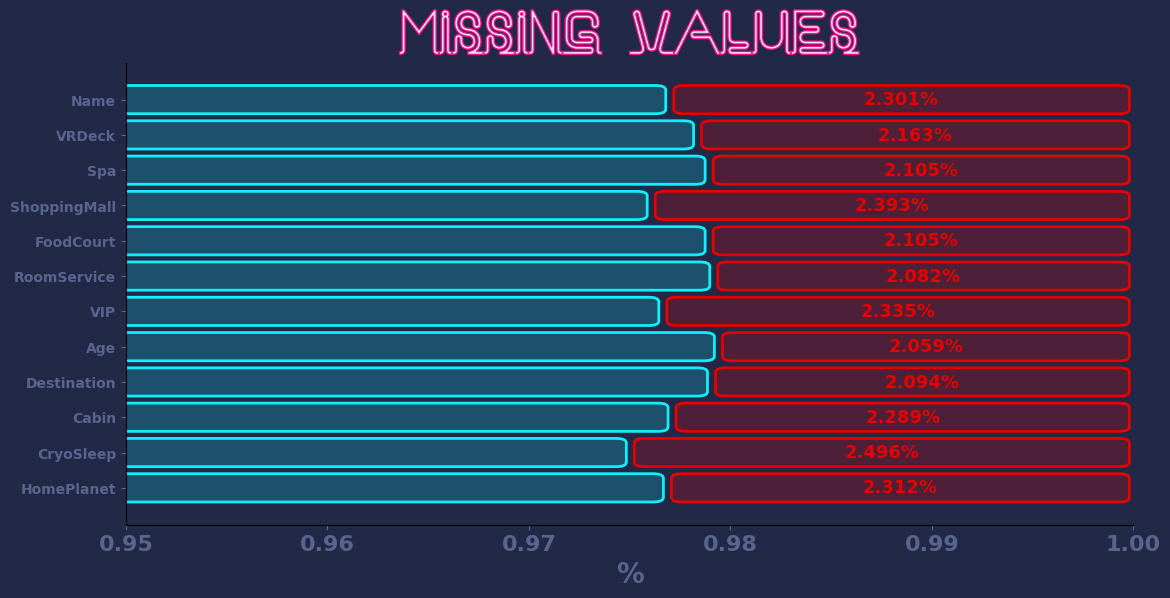

In [6]:
ax = fig.axes[0]
for i, column in enumerate(df_train.columns[1:-1]):
    missing_dt = (df_train[column].isna().sum()/len(df_train))
    ax.text(1-missing_dt/2, i,  f"{np.round(missing_dt*100, 3)}%", ha="center", va="center", c = "#e60000", size = 13)

ax.set_xlim([0.95, 1])
fig

<div class="alert alert-block alert-info">
<b>Takeaway:</b> Since missing values are a problem for all features, it is important to look into various solutions. Instead of just picking the mean for each feature, we might discover superior alternatives.</div>

### **Target: Transported**
> Our goal is to categorize whether a passenger was transported or not. Since the target looks to be evenly divided, around half of the people were transported.

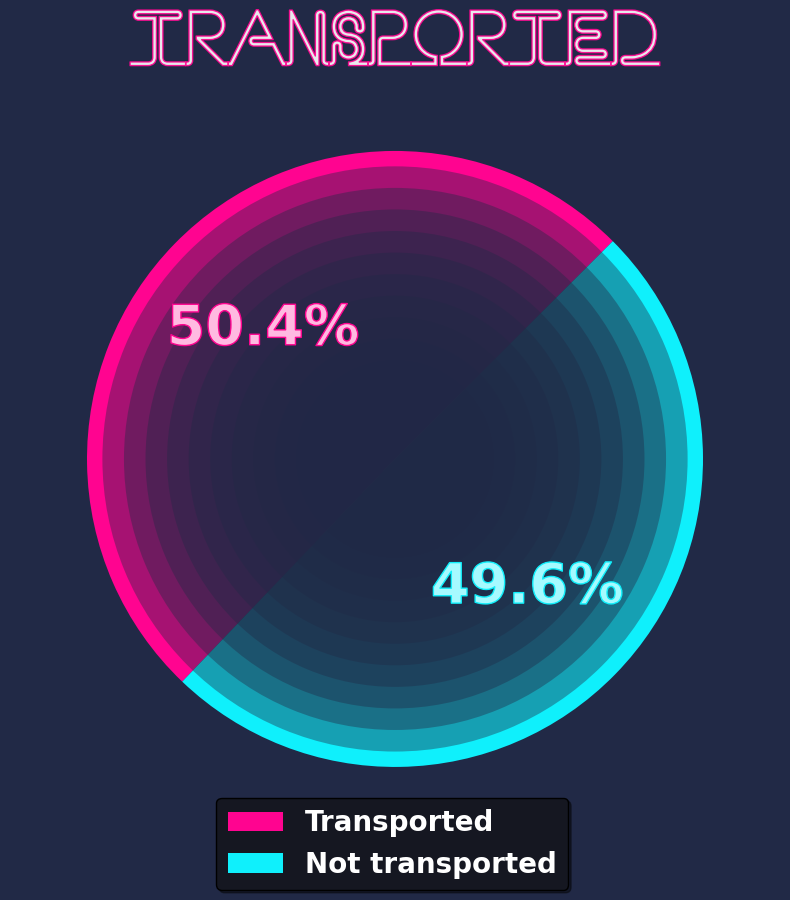

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
wedges, texts, autotexts = ax.pie(df_train.Transported.value_counts(), autopct='%1.1f%%', textprops=dict(color="w"), colors=["#ff0490", "#0ff0fc"], startangle=45)

plt.setp(autotexts[0], size=40, color="#ffbae1", path_effects=[path_effects.Stroke(linewidth=1, foreground="#ff0490")])
plt.setp(autotexts[1], size=40, color="#a6faff", path_effects=[path_effects.Stroke(linewidth=1, foreground="#0ff0fc")])

l = ax.legend(wedges, ["Transported", "Not transported"],
          loc="center left",
          bbox_to_anchor=(0.25, 0, 0, 0), prop={'size': 20}, facecolor="#151721", shadow=True, edgecolor="black")
for text in l.get_texts():
    text.set_color("white")

ax.set_title("Transported", size=50, c="white", path_effects=[path_effects.Stroke(linewidth=1, foreground="#ff0490", alpha=0.9)], family=title_font)

for i in range(10):
    ax.pie([1], colors=[bg_color], radius=0.95-i*0.07, wedgeprops = {"alpha": 0.4})

### **Age**

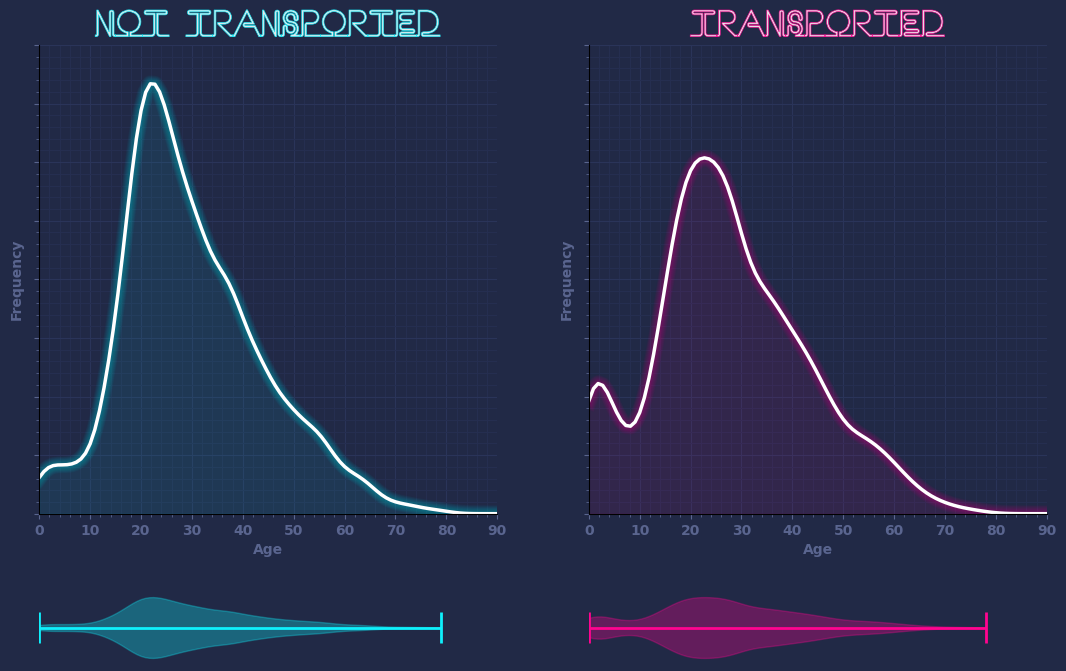

In [8]:
fig, axs_list = plt.subplots(2, 2, figsize=(13,8), gridspec_kw={"height_ratios": [7, 1]})
fig.subplots_adjust(hspace=0.3)

for i, axs in enumerate(axs_list.T):
    count = df_train[df_train["Transported"]==i].Age
    
    # KDE
    x = np.linspace(0, 90, 100)
    density = gaussian_kde(count.dropna())
    
    # Neon
    for j in range(1, 20):
        axs[0].plot(x, density(x), color=["#0ff0fc", "#ff0490"][i], lw=3+0.5*j, alpha=0.02)
    axs[0].plot(x, density(x), color="white", lw=2.5)

    axs[0].fill_between(x, density(x), x*0, alpha=0.08, color=["#0ff0fc", "#ff0490"][i])

    axs[0].set_xlabel("Age")
    axs[0].set_ylabel("Frequency")
    axs[0].set_title(["Not Transported", "Transported"][i], size=24, c="white", 
                    path_effects=[path_effects.Stroke(linewidth=0.5, foreground=["#0ff0fc", "#ff0490"][i], alpha=0.9)], family=title_font)

    # Grid
    axs[0].minorticks_on()
    axs[0].grid(True, which="major", c="#2A3459")
    axs[0].grid(True, which="minor", c="#252e50")
    axs[0].set_axisbelow(True)
    
    # Uniform axis
    axs[0].set_xlim([0, 90])
    axs[1].set_xlim([0, 90])
    axs[0].set_ylim([0, 0.04])
    axs[0].set_yticklabels([]);

    violin_parts = axs[1].violinplot(count.dropna(), vert=False);
    for part in violin_parts['bodies']:
        part.set_facecolor(["#0ff0fc", "#ff0490"][i])
        part.set_edgecolor(["#0ff0fc", "#ff0490"][i])

    for partname in ('cbars','cmins','cmaxes'):
        vp = violin_parts[partname]
        vp.set_edgecolor(["#0ff0fc", "#ff0490"][i])
        vp.set_linewidth(2)

    # Hide axis spine, ticks
    for txt in ["top","right","left","bottom"]:
            axs[1].spines[txt].set_visible(False)
    axs[1].xaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

<div class="alert alert-block alert-info">
<b>Takeaway:</b> Younger passengers had a higher risk of being transported.</div>

---

### **HomePlanet & Desination**


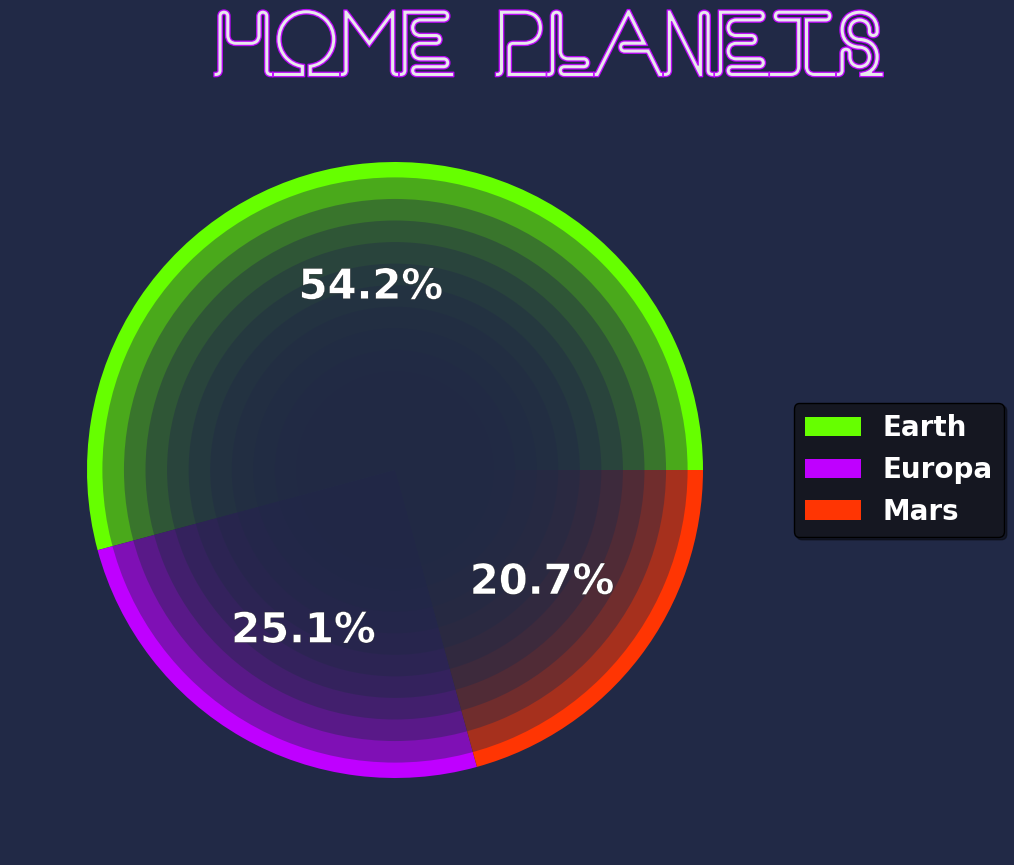

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
wedges, texts, autotexts = ax.pie(df_train.HomePlanet.value_counts(), autopct='%1.1f%%', textprops=dict(color="w"), colors=["#66ff00", "#bf00ff", "#ff3503"])

plt.setp(autotexts, size=30, color="white", path_effects=[path_effects.Stroke(linewidth=0.2, foreground="black")])

l = ax.legend(wedges, df_train.HomePlanet.value_counts().index,
          loc="center left",
          bbox_to_anchor=(1, 0.5, 0, 0), prop={'size': 20}, facecolor="#151721", shadow=True, edgecolor="black")
for text in l.get_texts():
    text.set_color("white")

ax.set_title("Home planets", size=60, c="white", path_effects=[path_effects.Stroke(linewidth=1, foreground="#bf00ff", alpha=0.9)], family=title_font, x=0.70)

for i in range(10):
    ax.pie([1], colors=[bg_color], radius=0.95-i*0.07, wedgeprops = {"alpha": 0.4})

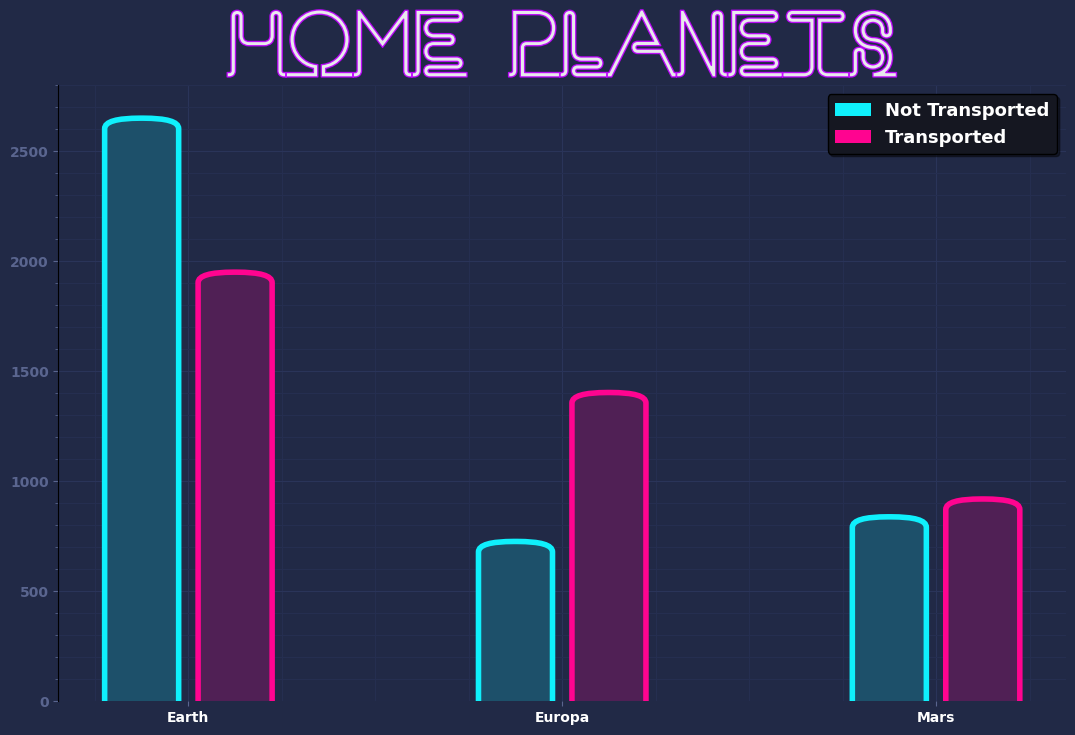

In [11]:
counts_planets = df_train.groupby("HomePlanet")["Transported"].value_counts()

fig, ax = plt.subplots(figsize=(13, 8))

ax.minorticks_on()
ax.grid(True, which="major", c="#2A3459")
ax.grid(True, which="minor", c="#252e50")
ax.set_axisbelow(True)

wedges, texts, autotexts = ax.bar(np.arange(3)*2, counts_planets[:,0]+100, bottom=-100, width = 0.4, color="#0ff0fc", label="Not Transported")
wedges2, texts2, autotexts = ax.bar(np.arange(3)*2+0.5, counts_planets[:,1]+100, bottom=-100, width = 0.4, color="#ff0490", label="Transported")

new_patches = []
for i, patch in enumerate(reversed(ax.patches)):
    bb = patch.get_bbox()
    color=patch.get_facecolor()
    if i in [0, 1, 2]:
        fc = "#502055"
    else: fc = "#1d506a"
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                        abs(bb.width), abs(bb.height),
                        boxstyle="round,pad=-0.0020,rounding_size=0.19",
                        ec=color, fc=fc, lw=4,
                        mutation_aspect=250
                        )
    patch.remove()
    new_patches.append(p_bbox)
for patch in new_patches:
    ax.add_patch(patch)

l = ax.legend([wedges, wedges2], ["Not Transported", "Transported"], prop={'size': 13}, facecolor="#151721", shadow=True, edgecolor="black")
for text in l.get_texts():
    text.set_color("white")

ax.set_xticks([0.25, 2.25, 4.25])
ax.set_xticklabels(["Earth", "Europa", "Mars"], color="white")
ax.tick_params(axis="x", which="minor", bottom=False)
ax.set_ylim([0, 2800])

for txt in ["top","right","bottom"]:
    ax.spines[txt].set_visible(False)

ax.set_title("Home planets", size=60, c="white", path_effects=[path_effects.Stroke(linewidth=1, foreground="#bf00ff", alpha=0.9)], family=title_font);

<div class="alert alert-block alert-info">
<b>Takeaway:</b> Home planets have a unique relationship with our target. A lesser percentage of passengers from Earth were transported, compared to a bigger percentage of passengers from Europa. It appears that there was an equal chance of transporting Martian passengers as there was not.</div>

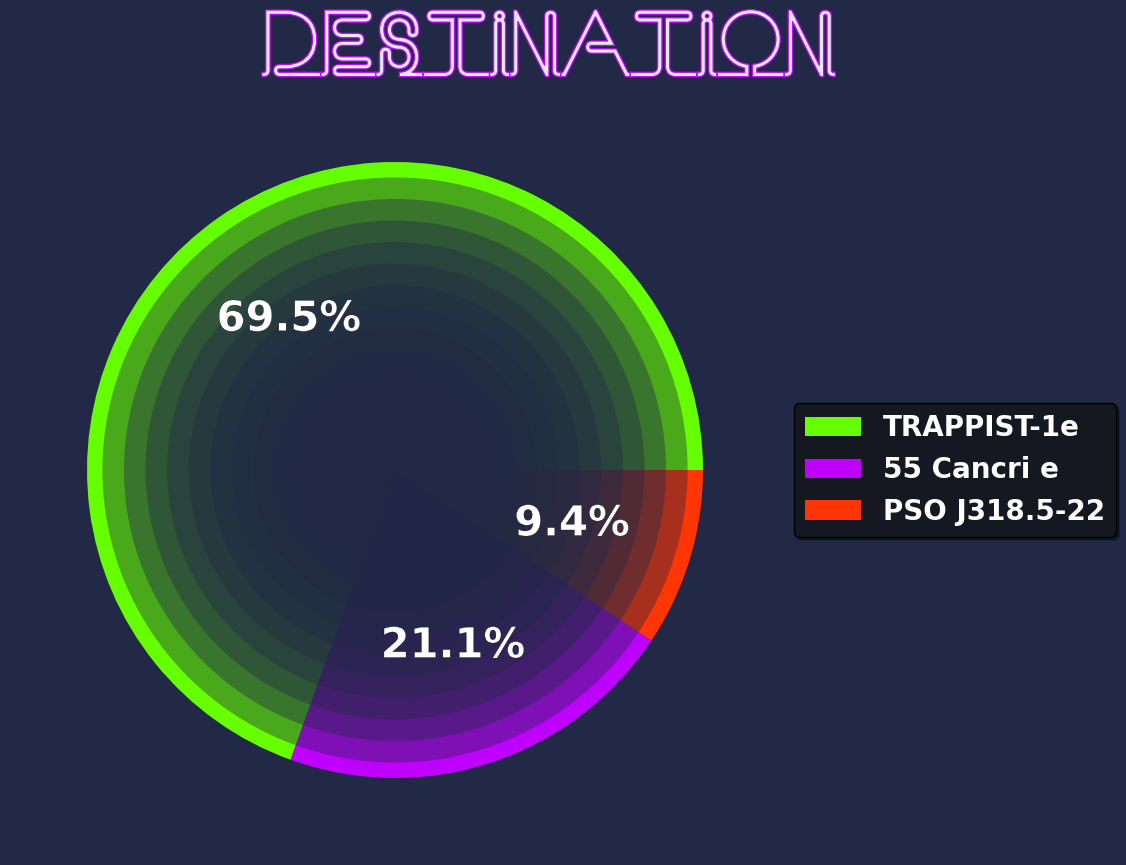

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
wedges, texts, autotexts = ax.pie(df_train.Destination.value_counts(), autopct='%1.1f%%', textprops=dict(color="w"), colors=["#66ff00", "#bf00ff", "#ff3503"])

plt.setp(autotexts, size=30, color="white", path_effects=[path_effects.Stroke(linewidth=0.2, foreground="black")])

l = ax.legend(wedges, df_train.Destination.value_counts().index,
          loc="center left",
          bbox_to_anchor=(1, 0.5, 0, 0), prop={'size': 20}, facecolor="#151721", shadow=True, edgecolor="black")
for text in l.get_texts():
    text.set_color("white")

ax.set_title("Destination", size=60, c="white", path_effects=[path_effects.Stroke(linewidth=1, foreground="#bf00ff", alpha=0.9)], family=title_font, x=0.70)

for i in range(10):
    ax.pie([1], colors=[bg_color], radius=0.95-i*0.07, wedgeprops = {"alpha": 0.4})

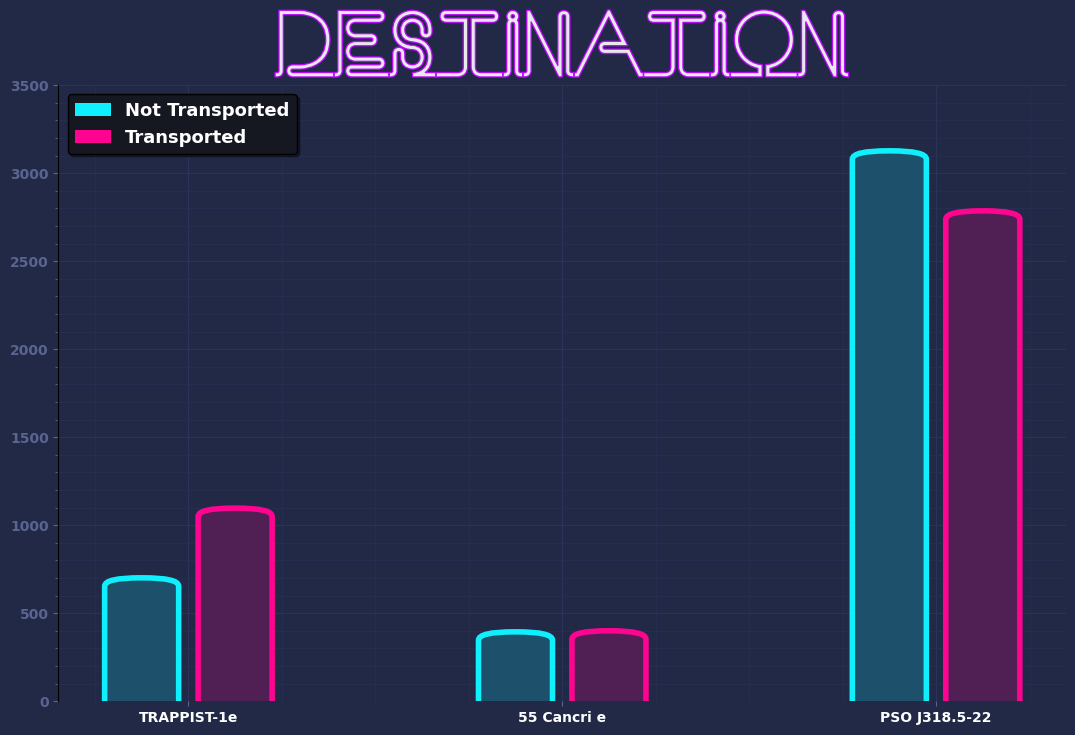

In [13]:
counts_destination = df_train.groupby("Destination")["Transported"].value_counts()

fig, ax = plt.subplots(figsize=(13, 8))

ax.minorticks_on()
ax.grid(True, which="major", c="#2A3459")
ax.grid(True, which="minor", c="#252e50")
ax.set_axisbelow(True)

wedges, texts, autotexts = ax.bar(np.arange(3)*2, counts_destination[:,0]+100, bottom=-100, width = 0.4, color="#0ff0fc", label="Not Transported")
wedges2, texts2, autotexts = ax.bar(np.arange(3)*2+0.5, counts_destination[:,1]+100, bottom=-100, width = 0.4, color="#ff0490", label="Transported")

l = ax.legend([wedges, wedges2], ["Not Transported", "Transported"], prop={'size': 13}, facecolor="#151721", shadow=True, edgecolor="black")
for text in l.get_texts():
    text.set_color("white")

new_patches = []
for i, patch in enumerate(reversed(ax.patches)):
    bb = patch.get_bbox()
    color=patch.get_facecolor()
    if i in [0, 1, 2]:
        fc = "#502055"
    else: fc = "#1d506a"
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                        abs(bb.width), abs(bb.height),
                        boxstyle="round,pad=-0.0020,rounding_size=0.19",
                        ec=color, fc=fc, lw=4,
                        mutation_aspect=250
                        )
    patch.remove()
    new_patches.append(p_bbox)
for patch in new_patches:
    ax.add_patch(patch)

ax.set_xticks([0.25, 2.25, 4.25])
ax.set_xticklabels(df_train.Destination.value_counts().index, color="white")
ax.tick_params(axis="x", which="minor", bottom=False)
ax.set_ylim([0, 3500])

for txt in ["top","right","bottom"]:
    ax.spines[txt].set_visible(False)

ax.set_title("Destination", size=60, c="white", path_effects=[path_effects.Stroke(linewidth=1, foreground="#bf00ff", alpha=0.9)], family=title_font);

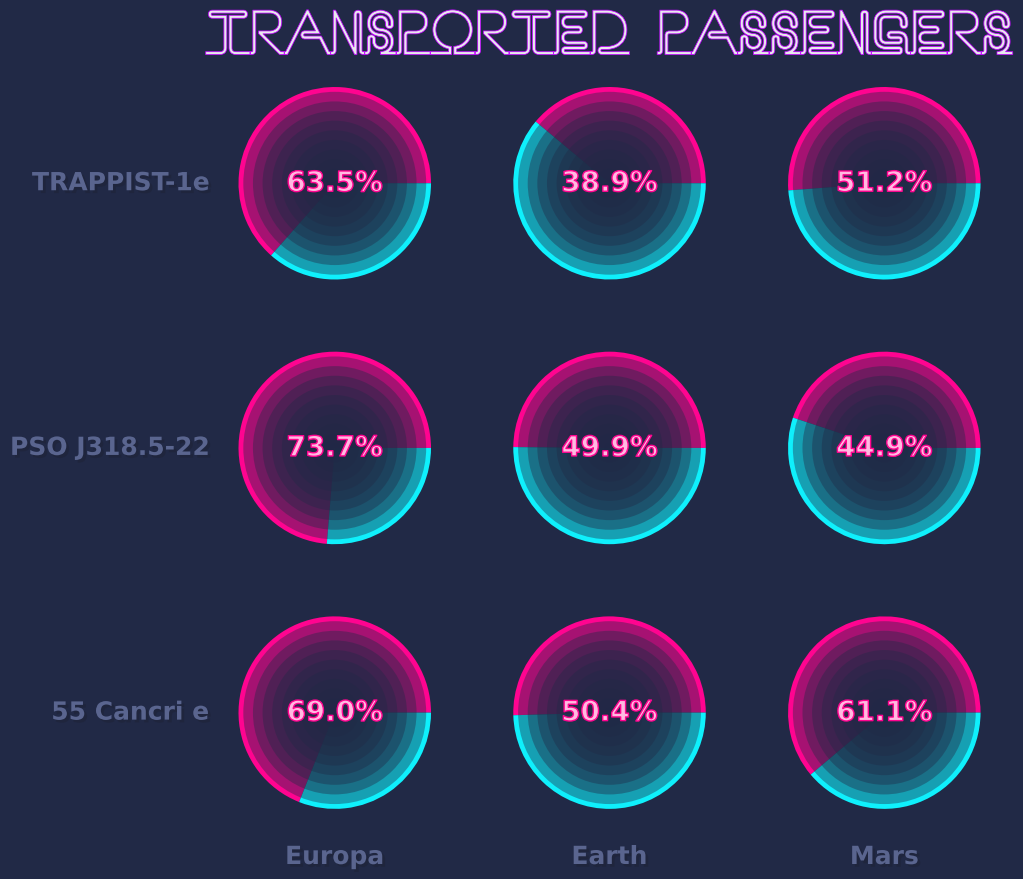

In [14]:
df_planets = df_train[["HomePlanet", "Destination", "Transported"]].dropna().value_counts()

fig, axs = plt.subplots(3, 3, figsize=(13, 10))
fig.subplots_adjust(wspace=-0.4, hspace=0.1)

for j, planet in enumerate(df_train.HomePlanet.dropna().unique()):

    for i, destination in enumerate(df_train.Destination.dropna().unique()):

        false_count = df_planets[planet][destination][False]
        true_count = df_planets[planet][destination][True]

        axs[i, j].pie([true_count, false_count], colors=["#ff0490", "#0ff0fc"])

        for k in range(10):
            axs[i, j].pie([1], colors=[bg_color], radius=0.95-k*0.1, wedgeprops = {"alpha": 0.4})

        axs[i, j].text(0, 0, f"{np.round(true_count/(false_count+true_count)*100,1)}%", ha="center", va="center", size=20, color="#ffbae1", path_effects=[path_effects.Stroke(linewidth=1, foreground="#ff0490")])

        # Destination txt
        if j == 0:
            axs[i, 0].text(-1.3, 0, destination, size=18, ha="right", va="center", c="#5a658f", path_effects=[path_effects.withSimplePatchShadow()])

    # Planet txt
    axs[2, j].text(0, -1.5, planet, size=18, ha="center", va="center", c="#5a658f", path_effects=[path_effects.withSimplePatchShadow()])
            
# Title
axs[0, 1].set_title("Transported Passengers", size=40, c="white", path_effects=[path_effects.Stroke(linewidth=0.6, foreground="#bf00ff", alpha=0.9)], family=title_font);

<div class="alert alert-block alert-warning">
<b> While the pie charts are appealing to the eye and simple to understand, they are very misleading in our case. The range of samples within combinations is wide, ranging from over 3000 to around 20. Bar plots are a better way to see this. </b>
</div>

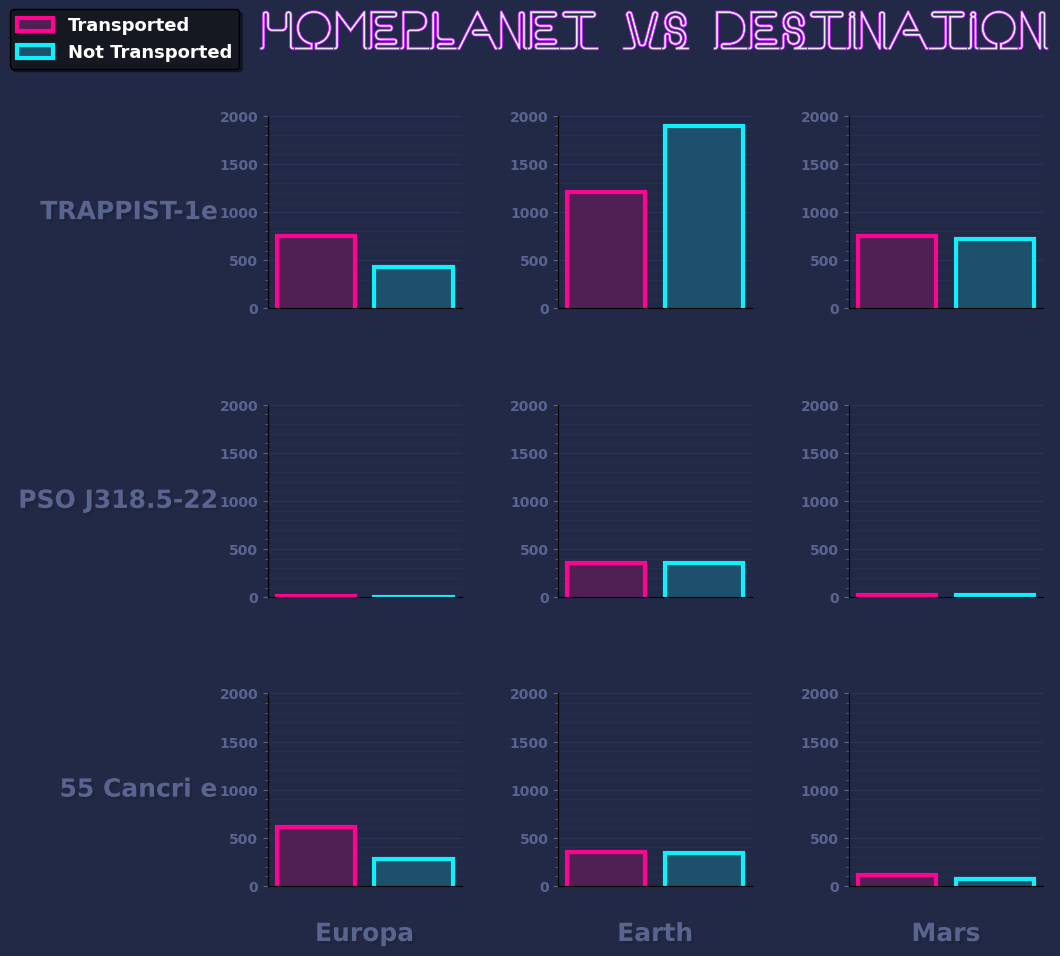

In [15]:
df_planets = df_train[["HomePlanet", "Destination", "Transported"]].dropna().value_counts()

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for j, planet in enumerate(df_train.HomePlanet.dropna().unique()):

    for i, destination in enumerate(df_train.Destination.dropna().unique()):

        false_count = df_planets[planet][destination][False]
        true_count = df_planets[planet][destination][True]

        wedges = axs[i, j].bar(1, true_count+100, bottom=-100, color="#502055", edgecolor="#ff0490", lw=3)
        wedges2 = axs[i, j].bar(2, false_count+100, bottom=-100,color="#1d506a", edgecolor="#0ff0fc", lw=3)

        # Destination txt
        if j == 0:
            axs[i, 0].text(0, 1000, destination, size=18, ha="right", va="center", c="#5a658f", path_effects=[path_effects.withSimplePatchShadow()])

        # Adjust y-axis
        axs[i, j].set_ylim([0, 2000])
        axs[i, j].set_xticks([])

        # Grid
        axs[i, j].minorticks_on()
        axs[i, j].grid(True, which="major", c="#2A3459")
        axs[i, j].grid(True, which="minor", c="#252e50")
        axs[i, j].set_axisbelow(True)

    # Planet txt
    axs[2, j].text(1.5, -500, planet, size=18, ha="center", va="center", c="#5a658f", path_effects=[path_effects.withSimplePatchShadow()])

# Legend
l = axs[0,0].legend([wedges, wedges2], ["Transported", "Not Transported"], prop={'size': 13}, facecolor="#151721", shadow=True, edgecolor="black", bbox_to_anchor=(-0.1, 1.6, 0, 0))
for text in l.get_texts():
    text.set_color("white")

# Title
axs[0, 1].set_title("HomePlanet Vs Destination", size=35, c="white", path_effects=[path_effects.Stroke(linewidth=0.6, foreground="#bf00ff", alpha=0.9)], family=title_font, y=1.3);

---
### **CryoSleep**

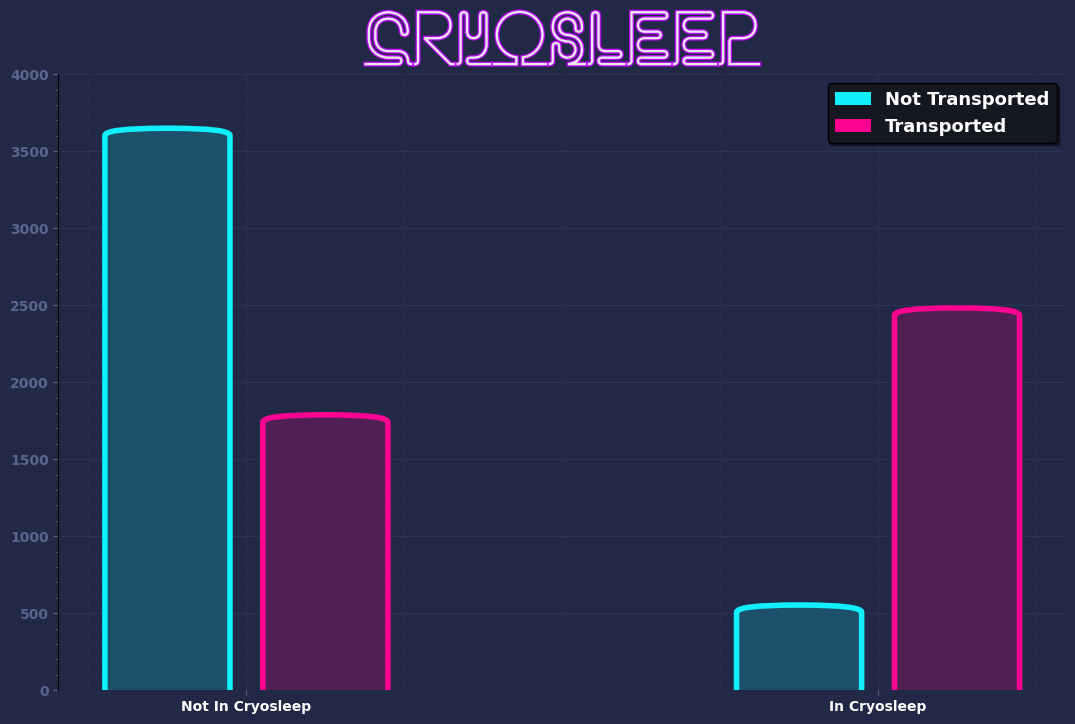

In [16]:
counts_cryosleep = df_train.groupby("CryoSleep")["Transported"].value_counts()

fig, ax = plt.subplots(figsize=(13, 8))

# Grid
ax.minorticks_on()
ax.grid(True, which="major", c="#2A3459")
ax.grid(True, which="minor", c="#252e50")
ax.set_axisbelow(True)

wedges, texts, = ax.bar(np.arange(2)*2, counts_cryosleep[:,0]+100, bottom=-100, width = 0.4, color="#0ff0fc", label="Not Transported")
wedges2, texts2 = ax.bar(np.arange(2)*2+0.5, counts_cryosleep[:,1]+100, bottom=-100, width = 0.4, color="#ff0490", label="Transported")

# Legend
l = ax.legend([wedges, wedges2], ["Not Transported", "Transported"], prop={'size': 13}, facecolor="#151721", shadow=True, edgecolor="black")
for text in l.get_texts():
    text.set_color("white")

# Round edges
new_patches = []
for i, patch in enumerate(reversed(ax.patches)):
    bb = patch.get_bbox()
    color=patch.get_facecolor()
    if i in [0, 1]:
        fc = "#502055"
    else: fc = "#1d506a"
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                        abs(bb.width), abs(bb.height),
                        boxstyle="round,pad=-0.0020,rounding_size=0.19",
                        ec=color, fc=fc, lw=4,
                        mutation_aspect=250
                        )
    patch.remove()
    new_patches.append(p_bbox)
for patch in new_patches:
    ax.add_patch(patch)

# Ticks
ax.set_xticks([0.25, 2.25])
ax.set_xticklabels(["Not In Cryosleep", "In Cryosleep"], color="white")
ax.tick_params(axis="x", which="minor", bottom=False)
ax.set_ylim([0, 4000])

for txt in ["top","right","bottom"]:
    ax.spines[txt].set_visible(False)

# Title
ax.set_title("CryoSleep", size=50, c="white", path_effects=[path_effects.Stroke(linewidth=1, foreground="#bf00ff", alpha=0.9)], family=title_font);

<div class="alert alert-block alert-info">
<b>Takeaway:</b> Passengers in cryosleep were more likely to be transported. When filling in missing values, this could be kept in mind. </div>

---
### **Luxury amenities and VIP**

In [17]:
features = df_train[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Transported"]].dropna()
features

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0.0,0.0,0.0,0.0,0.0,False
1,109.0,9.0,25.0,549.0,44.0,True
2,43.0,3576.0,0.0,6715.0,49.0,False
3,0.0,1283.0,371.0,3329.0,193.0,False
4,303.0,70.0,151.0,565.0,2.0,True
...,...,...,...,...,...,...
8688,0.0,6819.0,0.0,1643.0,74.0,False
8689,0.0,0.0,0.0,0.0,0.0,False
8690,0.0,0.0,1872.0,1.0,0.0,True
8691,0.0,1049.0,0.0,353.0,3235.0,False


> A large number of outliers make it difficult to visualize using boxplots. 

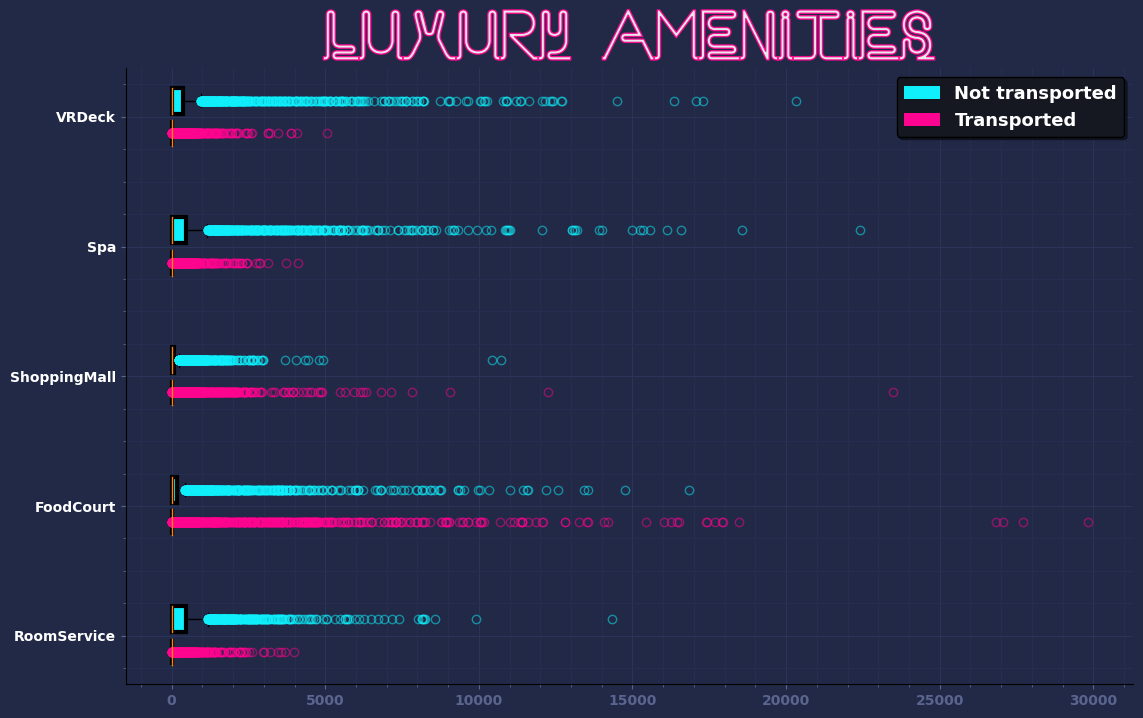

In [18]:
fig, ax = plt.subplots(1, figsize=(13, 8))

dt = features[features["Transported"]==False].drop("Transported", axis=1)
ax.boxplot(dt, patch_artist=True, widths= 0.4, 
            boxprops=dict(facecolor="#0ff0fc", color="black", linewidth=3), 
            flierprops=dict(color="#0ff0fc", markeredgecolor="#0ff0fc", alpha=0.5), 
            vert=False, positions=np.arange(1,11,2)+0.5)

dt = features[features["Transported"]==True].drop("Transported", axis=1)
ax.boxplot(dt, patch_artist=True, widths= 0.4, 
            boxprops=dict(facecolor="#ff0490", color="black", linewidth=3), 
            flierprops=dict(color="#ff0490", markeredgecolor="#ff0490", alpha=0.5), 
            vert=False, positions=np.arange(1,11,2))

# Grid & Ticks
ax.minorticks_on()
ax.grid(True, which="major", c="#2A3459")
ax.grid(True, which="minor", c="#252e50")
ax.set_axisbelow(True)
ax.set_yticks(np.arange(1,11,2)+0.25)
ax.set_yticklabels(features.columns.values[:-1], c="white")
ax.set_title("Luxury Amenities", size=45, c="white", path_effects=[path_effects.Stroke(linewidth=1, foreground="#ff0490", alpha=0.9)], family=title_font)

# Legend from another plot
l = ax.legend([wedges, wedges2], ["Not transported", "Transported"],
          loc="best", prop={'size': 13}, facecolor="#151721", shadow=True, edgecolor="black")
for text in l.get_texts():
    text.set_color("white")


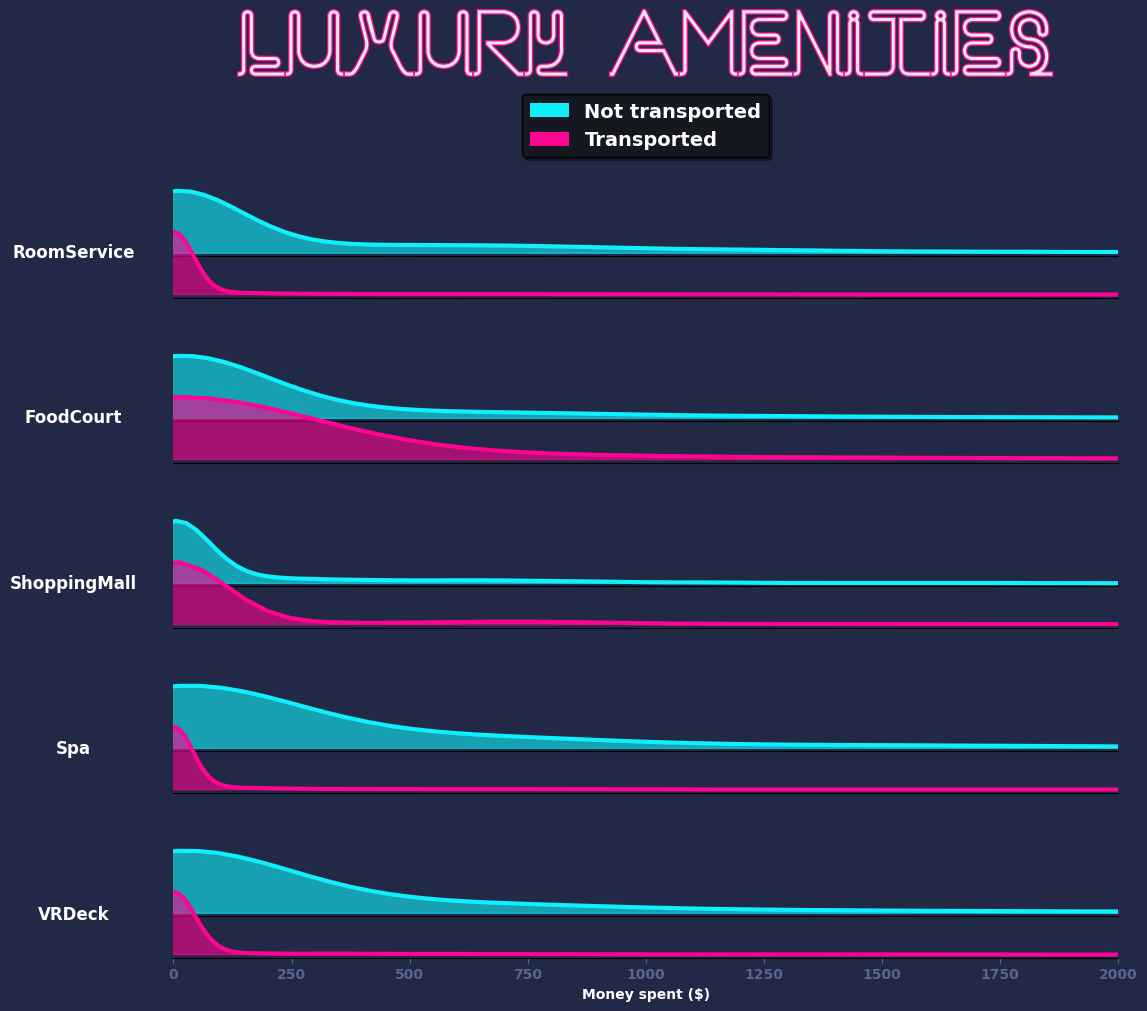

In [19]:
fig, axs = plt.subplots(18,2, figsize=(14, 10), gridspec_kw={'width_ratios': [1, 7]})
fig.subplots_adjust(wspace=0.01, hspace=-0.4)

colors=["#0ff0fc", "#ff0490"]

# Kde plot
for j in range(2):
    for i, column in enumerate(features.columns[:-1]):
        
        idx = i*4+j
        df = features[features["Transported"]==j][column]
        kde = df.plot.kde(ax = axs[idx, 1], color=colors[j], bw_method=0.15, lw=3)
        
        # Fill
        x = kde.get_children()[0]._x
        y = kde.get_children()[0]._y
        axs[idx,1].fill_between(x, y, color=colors[j], alpha=0.6)
        
        rect = axs[idx, 1].patch
        rect.set_alpha(0)
        
        # Uniform axes
        axs[idx,1].set_xlim(0, 2000)

# Hide axis information and make bg transparent
for i in range(18):
    rect = axs[i, 1].patch
    rect.set_alpha(0)

    axs[i,1].yaxis.set_visible(False)
    axs[i,1].xaxis.set_visible(False)

    for txt in ["top","right","left"]:
        axs[i,1].spines[txt].set_visible(False)

    if i in [2, 3, 6, 7, 10, 11, 14, 15]:
        axs[i,1].spines["bottom"].set_visible(False)
    
axs[0,1].tick_params(axis="x", which="both", colors = "#E2E2E2")
axs[0,1].xaxis.set_visible(False)

# Remove the underlying axes and create one big
gs = axs[0, 0].get_gridspec()
for ax in axs[:, 0]:
    ax.remove()
ax = fig.add_subplot(gs[:, 0])
ax.set_ylim(0,2)
for i, txt in enumerate(features.columns[:-1]):
    ax.text(0.3, 1.82-0.43*i, txt, c="white", ha="center", size=12, weight="bold")

# Hide axis spine, ticks
for txt in ["top","right","left","bottom"]:
        ax.spines[txt].set_visible(False)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

axs[17,1].xaxis.set_visible(True)
axs[17,1].set_xlabel("Money spent ($)", weight="bold", c="white")

# Use legend from another plot
l = axs[0,1].legend([wedges, wedges2], ["Not transported", "Transported"],
          loc="lower center",
          bbox_to_anchor=(0.5, 1.3, 0, 0), prop={'size': 14}, facecolor="#151721", shadow=True, edgecolor="black")
for text in l.get_texts():
    text.set_color("white")

axs[0,1].set_title("Luxury Amenities", size=60, c="white", path_effects=[path_effects.Stroke(linewidth=1, foreground="#ff0490", alpha=0.9)], family=title_font, y=2.5);

<div class="alert alert-block alert-info">
<b>Takeaway:</b> Less likely to be transported were passengers who spent more money on room service, at the spa, or at the VRDeck.</div>

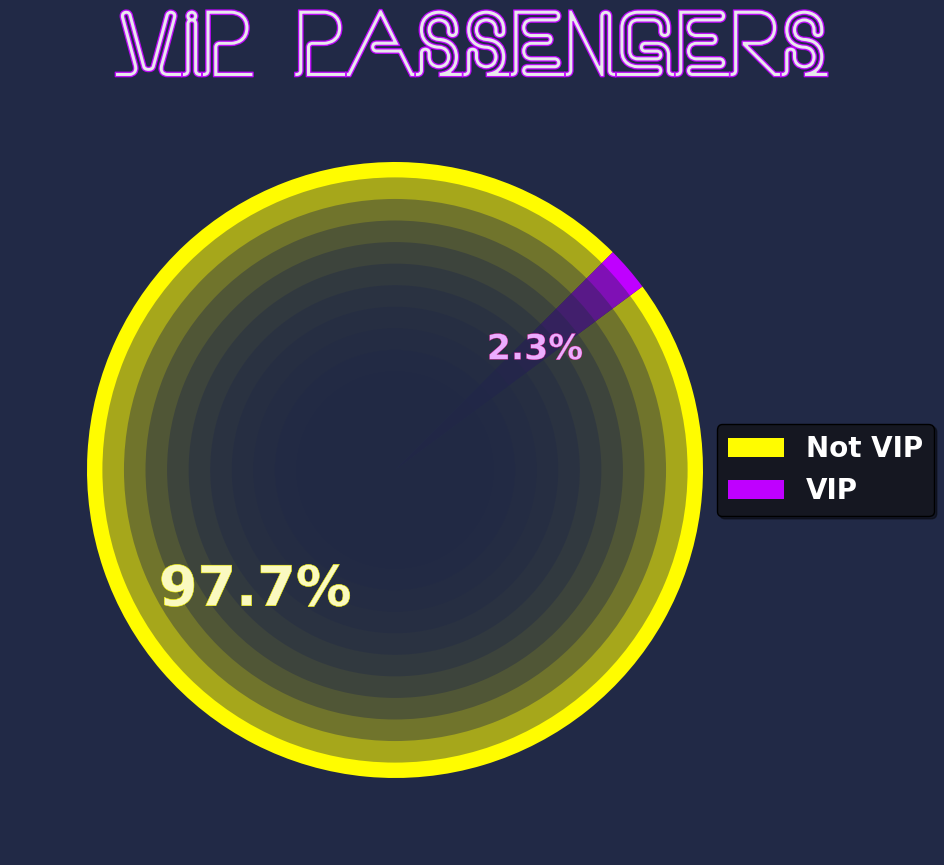

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
wedges, texts, autotexts = ax.pie(df_train["VIP"].value_counts(), autopct='%1.1f%%', textprops=dict(color="w"), colors=["#fffc00", "#bf00ff"], startangle=45)

plt.setp(autotexts[0], size=40, weight="bold", color="#faf9c0", path_effects=[path_effects.Stroke(linewidth=0.4, foreground="#fffc00")])
plt.setp(autotexts[1], size=25, weight="bold", color="#ebadff", path_effects=[path_effects.Stroke(linewidth=0.2, foreground="#ff0490")])

l = ax.legend(wedges, ["Not VIP", "VIP"],
          loc="center left",
          bbox_to_anchor=(0.9, 0.5, 0, 0), prop={'size': 20}, facecolor="#151721", shadow=True, edgecolor="black")
for text in l.get_texts():
    text.set_color("white")

ax.set_title("VIP Passengers", size=60, c="white", path_effects=[path_effects.Stroke(linewidth=1, foreground="#bf00ff", alpha=0.9)], family=title_font, x=0.6)

for i in range(10):
    ax.pie([1], colors=[bg_color], radius=0.95-i*0.07, wedgeprops = {"alpha": 0.4})

> How about people in cryosleep? Could they make any purchases?

In [21]:
df_train[df_train["CryoSleep"]==True][["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum()

RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
dtype: float64

<div class="alert alert-block alert-info">
<b>Takeaway:</b> People in cryosleep did not make any purchases. When filling in missing values, this could be kept in mind.</div>

> What about other travelers who didn't make any purchases? 

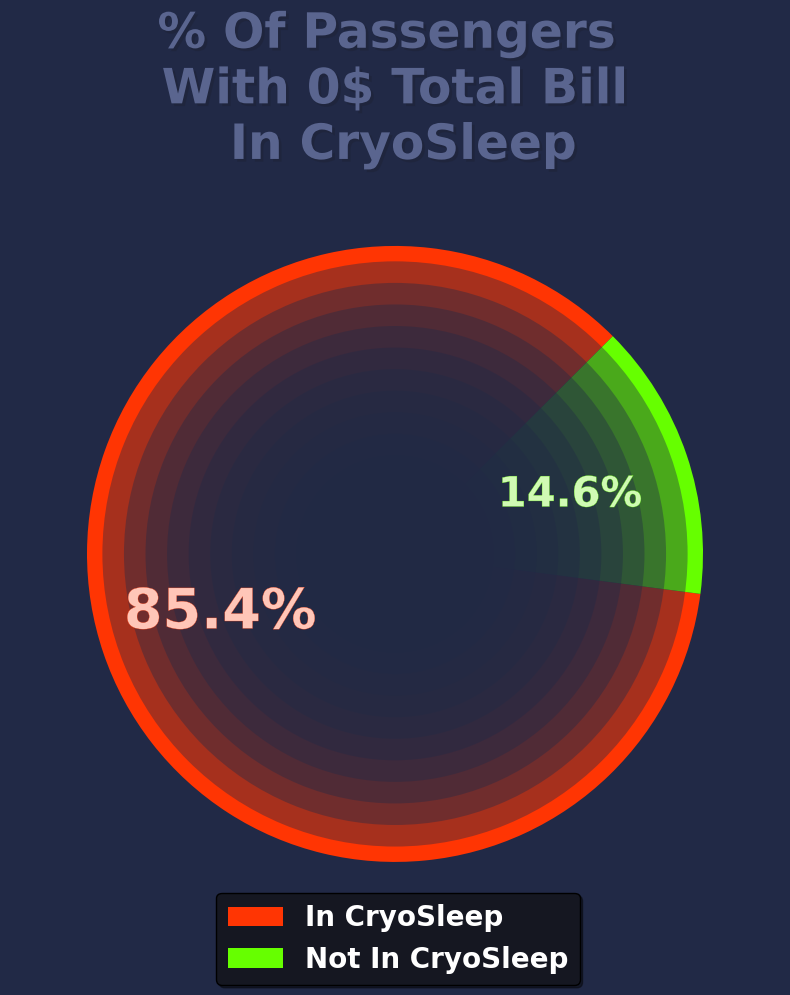

In [22]:
luxury_amenities = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
df_temp = df_train[df_train[luxury_amenities].sum(axis=1) == 0]

fig, ax = plt.subplots(figsize=(10, 10))
wedges, texts, autotexts = ax.pie(df_temp.CryoSleep.value_counts(), autopct='%1.1f%%', textprops=dict(color="w"), colors=["#ff3503", "#66ff00"], startangle=45)

plt.setp(autotexts[0], size=40, c="#ffc6b8", path_effects=[path_effects.Stroke(linewidth=0.2, foreground="#ff3503")])
plt.setp(autotexts[1], size=30, c="#d0fab4", path_effects=[path_effects.Stroke(linewidth=0.2, foreground="#66ff00")])

l = ax.legend(wedges, ["In CryoSleep", "Not In CryoSleep"],
          loc="center left",
          bbox_to_anchor=(0.25, 0, 0, 0), prop={'size': 20}, facecolor="#151721", shadow=True, edgecolor="black")
for text in l.get_texts():
    text.set_color("white")

ax.set_title("% Of Passengers \n With 0$ Total Bill \n In CryoSleep", size=35, c="#5a658f", path_effects=[path_effects.withSimplePatchShadow()])

for i in range(10):
    ax.pie([1], colors=[bg_color], radius=0.95-i*0.07, wedgeprops = {"alpha": 0.4})

<div class="alert alert-block alert-info">
<b>Takeaway:</b> Most of the people who did not buy anything were in Cryosleep. When filling in missing values, this could be kept in mind.</div>

> What about `Age`? In contrast to other age groups, children (`Age` < 13) have a bill of 0$.

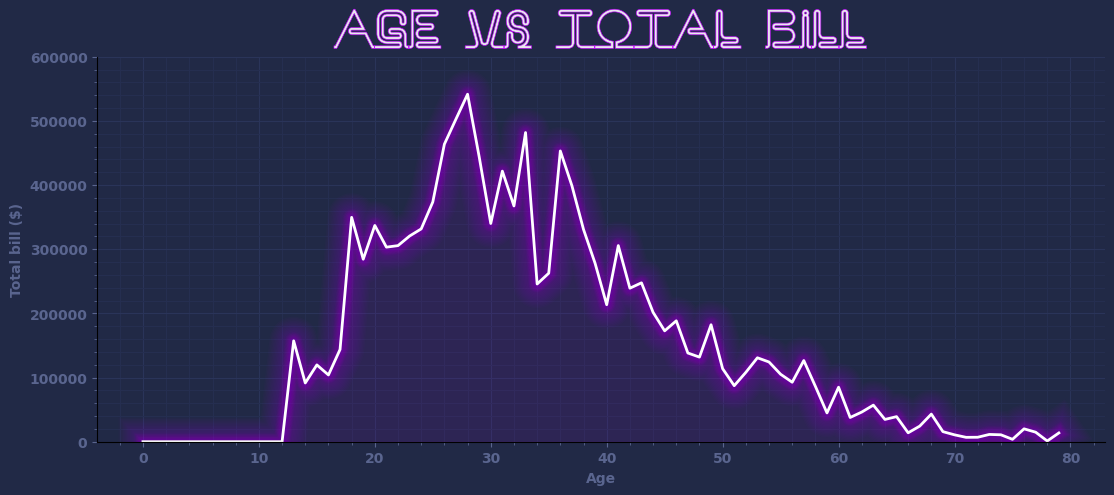

In [23]:
total_bill = df_train[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(1)
df_bill = pd.DataFrame({"Age": df_train.Age, "TotBill":total_bill})

dt = df_bill.groupby("Age").sum(1)

fig, ax = plt.subplots(figsize=(13,5))

# Neon
for j in range(1, 17):
    ax.plot(dt.index.values, dt.TotBill.values, color="#bf00ff", lw=3+0.6*j, alpha=0.02)
    ax.plot(dt.index.values, dt.TotBill.values, color="#bf00ff", lw=3+2*j, alpha=0.02)
ax.plot(dt.index.values, dt.TotBill.values, color="white", lw=2)
ax.fill_between(dt.index.values, dt.TotBill.values, dt.index.values*0, alpha=0.08, color="#bf00ff")

# Grid
ax.minorticks_on()
ax.grid(True, which="major", c="#2A3459")
ax.grid(True, which="minor", c="#252e50")
ax.set_axisbelow(True)

ax.set_xlabel("Age")
ax.set_ylabel("Total bill ($)")
ax.set_title("Age Vs Total Bill", size=35, c="white", path_effects=[path_effects.Stroke(linewidth=0.5, foreground="#bf00ff", alpha=0.9)], family=title_font)
ax.set_ylim([0, 600000]);

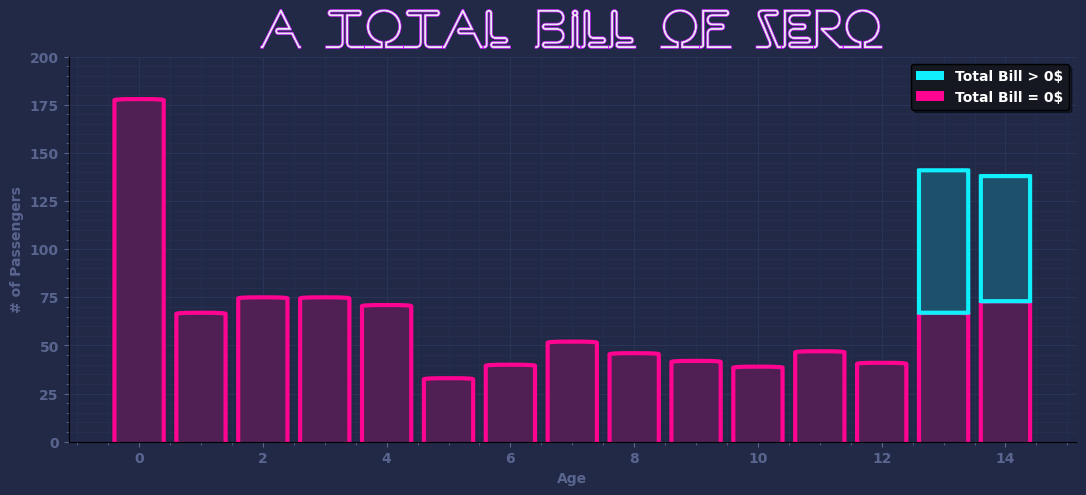

In [24]:
age_limit = 15

df_bill["Spender"] = df_bill.TotBill.apply(lambda x: x>0)
dt = df_bill[df_bill["Age"]<age_limit].groupby("Age")["Spender"].value_counts()

fig, ax = plt.subplots(figsize=(13,5))

# Grid
ax.minorticks_on()
ax.grid(True, which="major", c="#2A3459")
ax.grid(True, which="minor", c="#252e50")
ax.set_axisbelow(True)

# Bar plot
for age in range(age_limit):
    for idx in np.sort(dt[age].index):
        if len(dt[age].index) == 2:
            if idx == True:
                wedges = ax.bar(age, dt[age][idx], bottom=dt[age][False], color="#0ff0fc")
            else:
                wedges2 = ax.bar(age, dt[age][idx]+100, bottom=-100, color="#ff0490")
        else:
            if idx == True:
                wedges = ax.bar(age, dt[age][idx], color="#0ff0fc")
            else:
                wedges2 = ax.bar(age, dt[age][idx]+100, bottom=-100, color="#ff0490")

# Upgrade to Fancy barplot
new_patches = []
for i, patch in enumerate(reversed(ax.patches)):
    bb = patch.get_bbox()
    color=patch.get_facecolor()
    if color[0] == 1:
        lw = 3
        rounding_size = 0.3
        fc = "#502055"
        zorder = 1
    else:
        lw = 3
        rounding_size = 0.02
        fc = "#1d506a"
        zorder = 2
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle=f"round,pad=-0.0020,rounding_size={rounding_size}",
                            ec=color, fc=fc, lw=lw,
                            mutation_aspect=2, zorder=zorder
                            )
    patch.remove()
    new_patches.append(p_bbox)
for patch in new_patches:
    ax.add_patch(patch)

# Legend
l = ax.legend([wedges, wedges2], ["Total Bill > 0$", "Total Bill = 0$"], prop={'size': 10}, facecolor="#151721", shadow=True, edgecolor="black")
for text in l.get_texts():
    text.set_color("white")

ax.set_title("A Total Bill Of Zero", size=35, c="white", path_effects=[path_effects.Stroke(linewidth=0.5, foreground="#bf00ff", alpha=0.9)], family=title_font)
ax.set_xlabel("Age")
ax.set_ylabel("# of Passengers")
ax.set_ylim([0, 200]);

<div class="alert alert-block alert-info">
<b>Takeaway:</b> Passengers below the age of 13 will in majority not spend anything on luxury amenities. This information could perhaps be used to fill missing values.</div>

---
### **Cabins**

In [25]:
temp = df_train.Cabin.apply(lambda x : str(x).split("/"))
cabin_df = pd.DataFrame(temp.tolist(), index= temp.index)
cabin_df["Transported"] = df_train["Transported"]
cabin_df["VIP"] = df_train["VIP"]

print(" \033[1m", "# of passengers without cabin: ", df_train.Cabin.isna().sum(), "\033[0m")
print(" \033[1m", "# of unqiue cabins: ", df_train.Cabin.nunique(), "\033[0m")
print(" \033[1m", "# of decks: ", df_train.Cabin.dropna().apply(lambda x : str(x).split("/")[0]).nunique(), "\033[0m")

  # of passengers without cabin:  199 
  # of unqiue cabins:  6560 
  # of decks:  8 


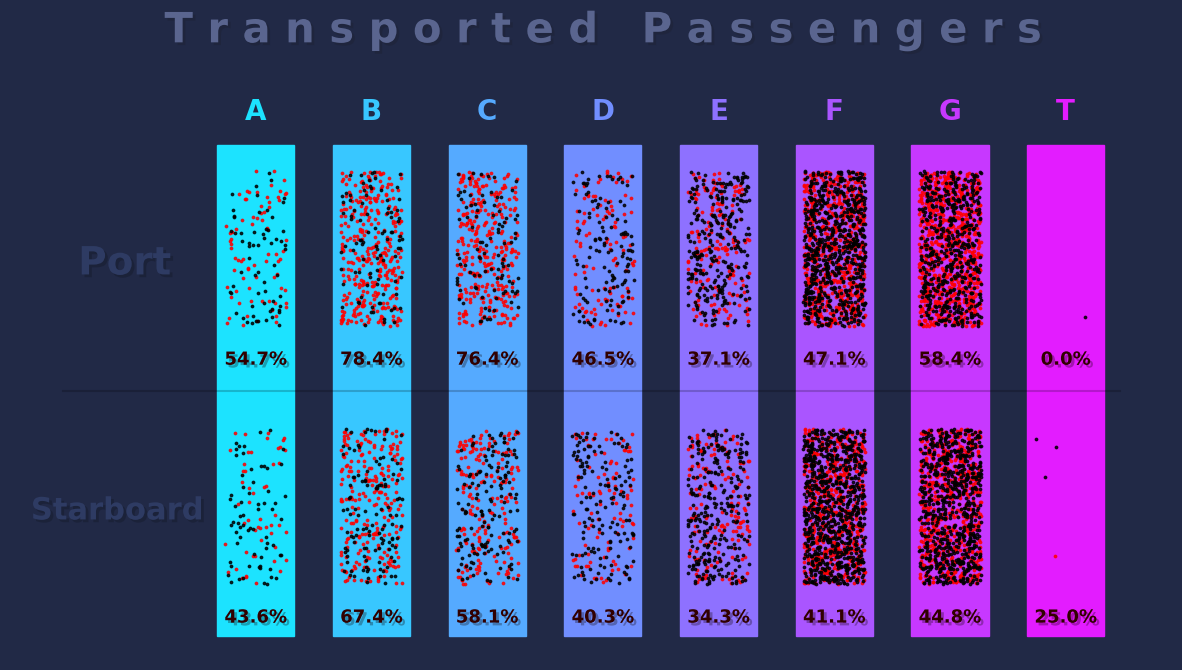

In [26]:
decks = sorted(df_train.Cabin.dropna().apply(lambda x : str(x).split("/")[0]).unique())   # Names of decks

fig, ax = plt.subplots(figsize=(15, 7))
fig.subplots_adjust(wspace=0.2)

c = sns.color_palette("cool", len(decks))

for i, deck in enumerate(decks):
    for j, side in enumerate(["P", "S"]):

        if i == len(decks)-1 and j == 1:
            labels = ["Transported", "Not Transported"]
        
        # Transported scatter
        dt = cabin_df[(cabin_df[0]==deck) & (cabin_df[2]==side) & (cabin_df["Transported"]==True)]
        ax.scatter(np.random.uniform(0.1, 0.9, size=len(dt))+i*1.5, np.random.uniform(0.2, 0.8, size=len(dt))+j*1, c="red", alpha=0.8, zorder=2, s=3)

        # Not Transported scatter
        dt2 = cabin_df[(cabin_df[0]==deck) & (cabin_df[2]==side) & (cabin_df["Transported"]==False)]
        ax.scatter(np.random.uniform(0.1, 0.9, size=len(dt2))+i*1.5, np.random.uniform(0.2, 0.8, size=len(dt2))+j*1, c="black", alpha=0.8, zorder=2, s=3)

        ax.text(0.5+i*1.5, 0.05+j, f"{np.round(len(dt)/(len(dt2)+len(dt))*100, 1)}%", size=13, ha="center", c="#310000", path_effects=[path_effects.withSimplePatchShadow()])

    # Deck bg
    ax.add_patch(Rectangle((i*1.5, 0), 1, 1.9, alpha=1, zorder=1, color=c[i]))
    ax.text(0.5+i*1.5, 2, deck, size=20, ha="center", c=c[i])

    # Hide axis spine, ticks
    for txt in ["top","right","left","bottom"]:
            ax.spines[txt].set_visible(False)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)

# Txt Starboard and Port
ax.text(-1.2, 1.4, "Port", size=28, ha="center", c="#2e3b63", path_effects=[path_effects.withSimplePatchShadow()])
ax.text(-1.3, 0.45, "Starboard", size=22, ha="center", c="#2e3b63", path_effects=[path_effects.withSimplePatchShadow()])

# Line
ax.plot([-2, 11.7], [0.95, 0.95], c="black", alpha=0.2)

# Title
ax.text(5, 2.3, " ".join("Transported Passengers"), size=30, ha="center", c="#5a658f", path_effects=[path_effects.withSimplePatchShadow()]);   

<div class="alert alert-block alert-info">
<b>Takeaway:</b> On all decks, port-side cabin occupants were more likely to be transported than starboard-side occupants.</div>

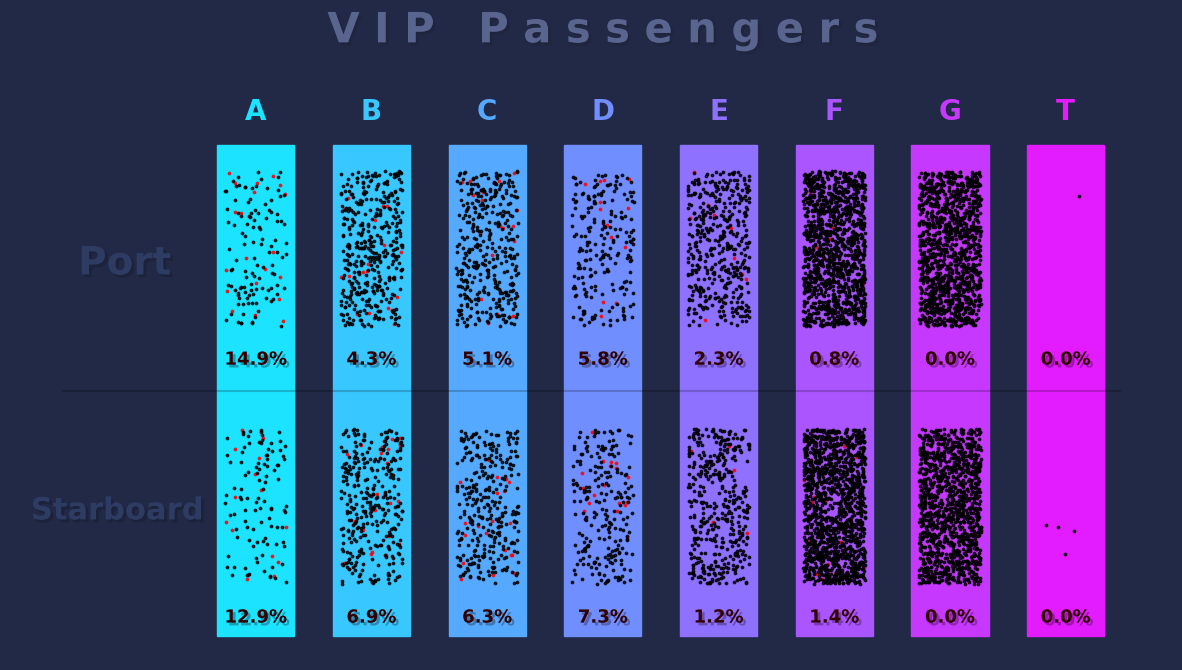

In [27]:
decks = sorted(df_train.Cabin.dropna().apply(lambda x : str(x).split("/")[0]).unique())   # Names of decks

fig, ax = plt.subplots(figsize=(15, 7))
fig.subplots_adjust(wspace=0.2)

c = sns.color_palette("cool", len(decks))

for i, deck in enumerate(decks):
    for j, side in enumerate(["P", "S"]):

        if i == len(decks)-1 and j == 1:
            labels = ["Transported", "Not Transported"]
        
        # VIP scatter
        dt = cabin_df[(cabin_df[0]==deck) & (cabin_df[2]==side) & (cabin_df["VIP"]==True)]
        ax.scatter(np.random.uniform(0.1, 0.9, size=len(dt))+i*1.5, np.random.uniform(0.2, 0.8, size=len(dt))+j*1, c="red", alpha=0.8, zorder=2, s=3)

        # Not VIP scatter
        dt2 = cabin_df[(cabin_df[0]==deck) & (cabin_df[2]==side) & (cabin_df["VIP"]==False)]
        ax.scatter(np.random.uniform(0.1, 0.9, size=len(dt2))+i*1.5, np.random.uniform(0.2, 0.8, size=len(dt2))+j*1, c="black", alpha=0.8, zorder=2, s=3)

        ax.text(0.5+i*1.5, 0.05+j, f"{np.round(len(dt)/(len(dt2)+len(dt))*100, 1)}%", size=13, ha="center", c="#310000", path_effects=[path_effects.withSimplePatchShadow()])

    # Deck bg
    ax.add_patch(Rectangle((i*1.5, 0), 1, 1.9, alpha=1, zorder=1, color=c[i]))
    ax.text(0.5+i*1.5, 2, deck, size=20, ha="center", c=c[i])

    # Hide axis spine, ticks
    for txt in ["top","right","left","bottom"]:
            ax.spines[txt].set_visible(False)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)

# Txt Starboard and Port
ax.text(-1.2, 1.4, "Port", size=28, ha="center", c="#2e3b63", path_effects=[path_effects.withSimplePatchShadow()])
ax.text(-1.3, 0.45, "Starboard", size=22, ha="center", c="#2e3b63", path_effects=[path_effects.withSimplePatchShadow()])

# Line
ax.plot([-2, 11.7], [0.95, 0.95], c="black", alpha=0.2)

# Title
ax.text(5, 2.3, " ".join("VIP Passengers"), size=30, ha="center", c="#5a658f", path_effects=[path_effects.withSimplePatchShadow()]);   

---
# **XGBoost**
> Here is a simple XGBoost implementation that can be used as a starting point for more complex modeling. On the test set, it will yield an accuracy of 79%.

### **Data Preprocessing**
> Preprocessing is carried out in a straightforward manner. Our first model will serve as a starting point that can be enhanced.
1. **Missing values.** XGBoost is able to handle missing values which is great for us to create a baseline. One thing we can incorporate is how passengers in `CryoSleep` can not spend anything on luxury amenities.
2. **Simple feature enginnering.** Extracting `GroupId`, `Deck` and `Side` information from other features.
3. **Adjust dtypes** since XGBoost does not natively support categorical data, thus all `object` type columns must be looked over. Both `CryoSleep` and `VIP` can be specified as boolean types. For **One-Hot Encoding**, we use the `get_dummies()` from pandas since our data is already stored as a pandas DataFrame.

In [ ]:
def preprocessing(df, train=True, age_limit=15):

    ### 1. Handle missing values
    # 1.1 Fill missing values regarding luxury amenities for people in CryoSleep, should all be zero.
    luxury_amenities = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
    df.loc[df.CryoSleep==1, luxury_amenities] = df.loc[df.CryoSleep==1, luxury_amenities].fillna(0)

    ### 2. Feature engineering
    # 2.1 Extract Group_id from PassengerId
    df["GroupId"] = df.PassengerId.apply(lambda x: x.split("_")[-1])

    # 2.2 Extract Deck and Side from Cabin information
    df["Deck"] = df.Cabin.apply(lambda x : str(x).split("/")[0])
    df["Side"] = df.Cabin.apply(lambda x : str(x).split("/")[-1])

    # 2.3 Specify if passenger is of young age. 
    df['AgeGroup'] = np.where(df['Age'] < age_limit, True, False)

    ### 3. Data types
    # 3.1 Specify boolean types
    df[["CryoSleep", "VIP",]] = df[["CryoSleep", "VIP"]].astype("bool")

    # 3.2 One-Hot Encoding
    if train:
        X = df.drop(["PassengerId", "Cabin", "Name", "Transported"], axis=1)
        y = df["Transported"]
    else:
        X = df.drop(["PassengerId", "Cabin", "Name"], axis=1)
        y = None   # No response for test set
    X = pd.get_dummies(X, drop_first = True)

    return X, y


In [ ]:
df_train = pd.read_csv(f'{directory_path}train.csv')

X, y = preprocessing(df_train)
X

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,AgeGroup,HomePlanet_Europa,...,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_nan,Side_S,Side_nan
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,...,1,0,0,0,0,0,0,0,0,0
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,False,0,...,0,0,0,0,1,0,0,0,1,0
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,1,...,0,0,0,0,0,0,0,0,1,0
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,1,...,0,0,0,0,0,0,0,0,1,0
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,False,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,False,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,1,...,0,0,0,0,0,0,0,0,0,0
8689,True,18.0,False,0.0,0.0,0.0,0.0,0.0,False,0,...,0,0,0,0,0,1,0,0,1,0
8690,False,26.0,False,0.0,0.0,1872.0,1.0,0.0,False,0,...,0,0,0,0,0,1,0,0,1,0
8691,False,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,1,...,0,0,0,1,0,0,0,0,1,0


---
### **XGBoost: Building the model**

In [ ]:
# Validation split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

model = XGBClassifier(objective="binary:logistic", seed=42)

model.fit(x_train, 
        y_train,
        verbose=0,
        eval_set=[(x_test, y_test)])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

## **Inference**

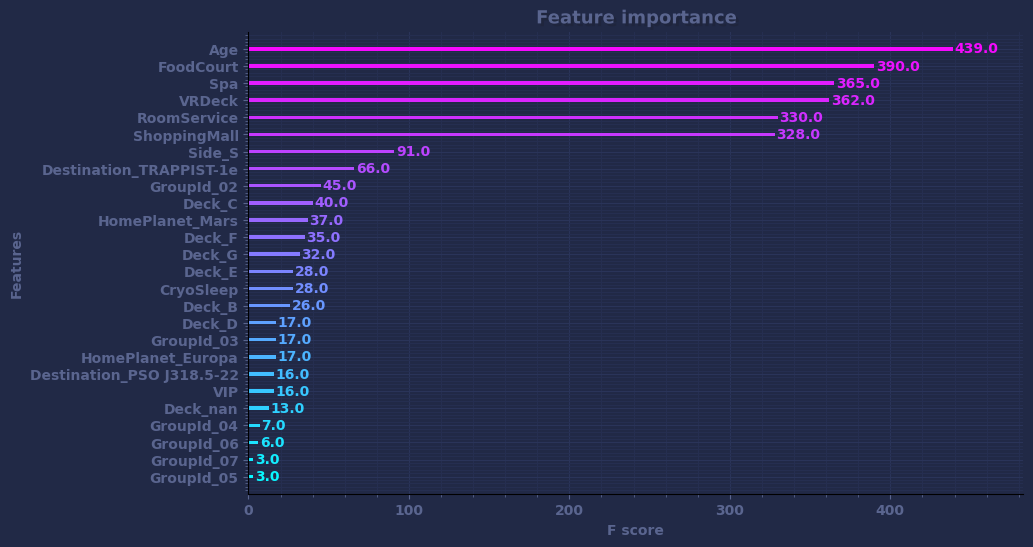

In [ ]:
ax = xgb.plot_importance(model, ax=plt.gca())
ax.set_title("Feature importance", size=13, c="#5a658f", path_effects=[path_effects.withSimplePatchShadow()])
ax.set_axisbelow(True)

fig = ax.get_figure()
fig.set_size_inches(10, 6)

c = sns.color_palette("cool", len(ax.patches))[::-1]
for i, patch in enumerate(reversed(ax.patches)):
    patch.set_facecolor(c[i])

    # Txt color
    ax.get_children()[26:52][i].set_color(c[::-1][i])

# Grid
ax.minorticks_on()
ax.grid(True, which="major", c="#2A3459")
ax.grid(True, which="minor", c="#252e50")
ax.set_axisbelow(True)

### **Confusion matrix**

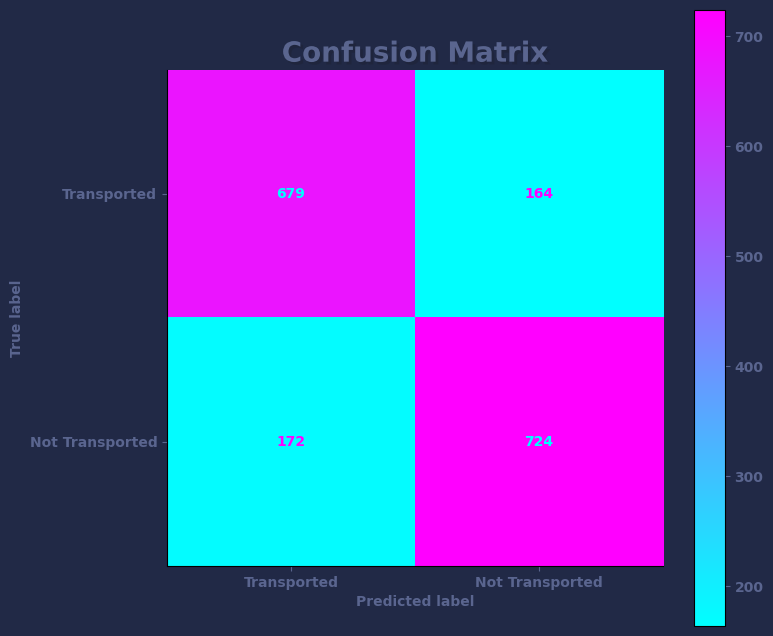

In [ ]:
pred = model.predict(x_test)

fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_test, pred, cmap="cool", ax=ax, display_labels=["Transported", "Not Transported"])
ax.set_title("Confusion Matrix", size=20, c="#5a658f", path_effects=[path_effects.withSimplePatchShadow()]);

---

## **Optimize Parameters**

**XGBoost** is strong, but requires tuning of hypterparameters.

### **Search #1**

In [ ]:
#param_grid = {"learning_rate":[0.1, 0.01, 0.05],
#            "gamma" : [0, 0.25, 1.0],
#            "reg_lambda" : [0, 1.0, 10.0]
#}

# Gamma: Regularisation parameter. Minimum loss reduction required to make a further partition on a leaf node of the tree.
# reg_lambda: L2 regularization term on weights. Increasing this value will make model more conservative.

#from sklearn.model_selection import GridSearchCV # Cross validation
#
#clf = GridSearchCV(
#    estimator=xgb.XGBClassifier(objective="binary:logistic", 
#                                seed=42, 
#                                subsample=0.8),
#    param_grid=param_grid,
#    scoring="roc_auc",
#    verbose=1,
#    cv=10)
#
#clf.fit(x_train, y_train)
#clf.best_params_

Output: {'gamma': 1.0, 'learning_rate': 0.05, 'reg_lambda': 0}

### **Search #2**

In [ ]:
#param_grid = {"learning_rate":[0.04, 0.05, 0.06],
#            "gamma" : [1, 1.5, 2],
#            "reg_lambda" : [0, 0.1, 0.2]
#}

#clf = GridSearchCV(
#    estimator=xgb.XGBClassifier(objective="binary:logistic", 
#                                seed=42, 
#                                subsample=0.8),
#    param_grid=param_grid,
#    scoring="roc_auc",
#    verbose=1,
#    cv=10)

#clf.fit(x_train, y_train)
#clf.best_params_ 

Output: {'gamma': 2, 'learning_rate': 0.05, 'reg_lambda': 0.2}

### **Search #3**

In [ ]:
#param_grid = {"learning_rate":[0.05],
#            "gamma" : [2, 3, 4],
#            "reg_lambda" : [0.2, 0.3, 0.4]
#}
#
#clf = GridSearchCV(
#    estimator=xgb.XGBClassifier(objective="binary:logistic", 
#                                seed=42, 
#                                subsample=0.8),
#    param_grid=param_grid,
#    scoring="roc_auc",
#    verbose=1,
#    cv=10)
#
#clf.fit(x_train, y_train)
#clf.best_params_

Output: {'gamma': 2, 'learning_rate': 0.05, 'reg_lambda': 0.2}

### **Final model**
> Let's' use these hyperparameters for our final model.

In [ ]:
model = XGBClassifier(objective="binary:logistic", seed=42, gamma=2, learning_rate=0.05, reg_lambda=0.2)

model.fit(x_train, 
        y_train,
        verbose=0,
        eval_set=[(x_test, y_test)])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=2, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=0.2, ...)

### **Submission**

In [ ]:
df_test = pd.read_csv(f'{directory_path}test.csv')

PassengerID = df_test["PassengerId"]
X, _ = preprocessing(df_test, train=False)

submission = pd.DataFrame({"PassengerID": PassengerID, "Transported":model.predict(X).astype(bool)})

submission.to_csv("submission.csv", index=False)

> What to do now?
* Better handling of missing values.
* Further feature engineering. 
* Further exploration of features considered important to the model.